## Install Libraries

In [1]:
%pip install tensorflow tensorflow-datasets pydot


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l2

2024-07-14 08:42:26.878434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 08:42:26.897763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 08:42:26.915840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 08:42:26.935434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 08:42:26.940528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 08:42:26.954038: I tensorflow/core/platform/cpu_feature_gu

## Load Data

In [3]:
(train_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split=('train[:80%]', 'train[80%:]'),
    with_info=True,
    as_supervised=True)

## Data Exploration

In [4]:
len(train_dataset), len(test_dataset)

(18610, 4652)

In [5]:
for X, y in train_dataset:
    print(X.shape, y.numpy())
    image_1 = X.numpy()
    break

(262, 350, 3) 1


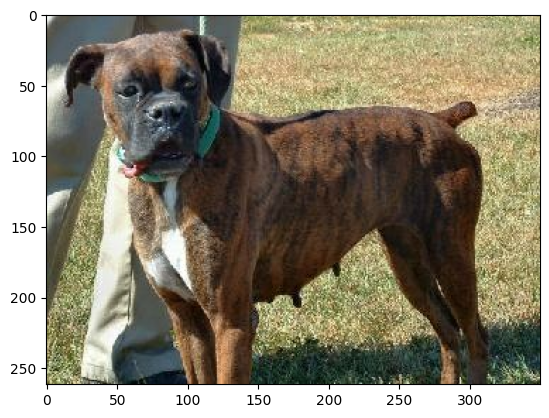

In [6]:
plt.imshow(image_1)

## Setup Helper Functions

In [9]:
def normalize_img(image, label):
    return ((tf.cast(image, tf.float32)) / 255.0, label)

def resize(image, label):
    return (tf.image.resize(image, (224,224)), label)

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

def augment(image, label):
    return data_augmentation(image), label

## Pre-process Image Data

In [10]:
train_dataset = train_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

ValueError: in user code:

    File "/tmp/ipykernel_1221395/2031190023.py", line 8, in augment  *
        image = RandomFlip("horizontal")(image)
    File "/home/mirai/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/layers/preprocessing/random_flip.py", line 45, in __init__  **
        self.generator = SeedGenerator(seed)
    File "/home/mirai/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/random/seed_generator.py", line 75, in __init__
        self.state = self.backend.Variable(
    File "/home/mirai/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/backend/common/variables.py", line 165, in __init__
        self._initialize(value)
    File "/home/mirai/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py", line 31, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [ ]:
SHUFFLE_VAL = len(train_dataset) // 1000
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
for (img, label) in train_dataset:
    print(img.numpy().shape, label.numpy())
    break

(32, 224, 224, 3) [1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0]


## Building the Model

In [ ]:
def ModifiedAlexNet():
    inp = Input((224, 224, 3))
    x = Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', kernel_regularizer=l2(0.01))(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Conv2D(filters=256, kernel_size=5, strides=1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Conv2D(filters=384, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Conv2D(filters=384, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units=4096, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=4096, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)

    return model

In [ ]:
modified_model = ModifiedAlexNet()
modified_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 22, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,586,689 (82.35 MB)

 Trainable params: 21,585,985 (82.34 MB)

 Non-trainable params: 704 (2.75 KB)

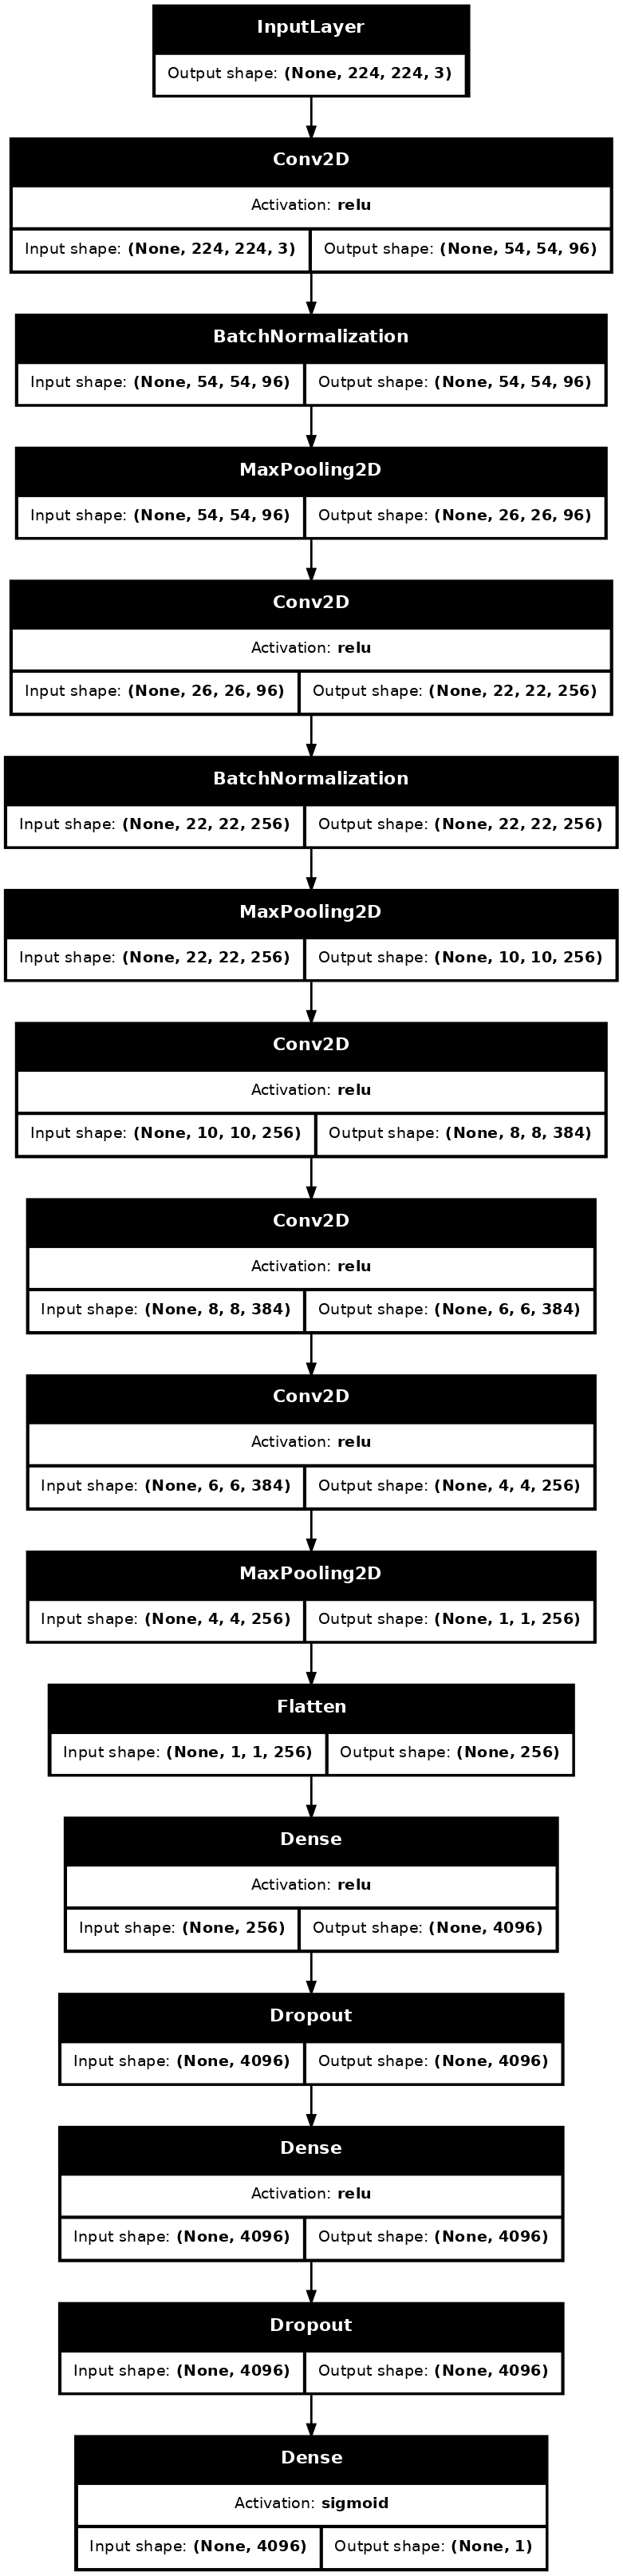

In [ ]:
plot_model(modified_model,
           to_file='./images/modified_model.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=False,
           show_layer_activations=True,
           dpi=100)

In [ ]:
modified_model.compile(loss=BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.00001),
                    metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=10,
                   monitor='val_loss',
                   restore_best_weights=True)

In [ ]:
modified_model_history = modified_model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[es])

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.6073 - loss: 0.6615 - val_accuracy: 0.7324 - val_loss: 0.5511
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.7622 - loss: 0.4838 - val_accuracy: 0.8027 - val_loss: 0.4193
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.8264 - loss: 0.3767 - val_accuracy: 0.8003 - val_loss: 0.4191
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 592s 1s/step - accuracy: 0.8682 - loss: 0.3012 - val_accuracy: 0.8224 - val_loss: 0.3984
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.8977 - loss: 0.2361 - val_accuracy: 0.8377 - val_loss: 0.3708
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.9141 - loss: 0.2001 - val_accuracy: 0.8515 - val_loss: 0.3618
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 597s 1s/step - accuracy: 0.9363 - loss: 0.1585 - val_accuracy: 0.7777 - val_loss: 0.6803
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9478 - loss: 0.1289 - val_accu

## Plot Training History

### Modified Model

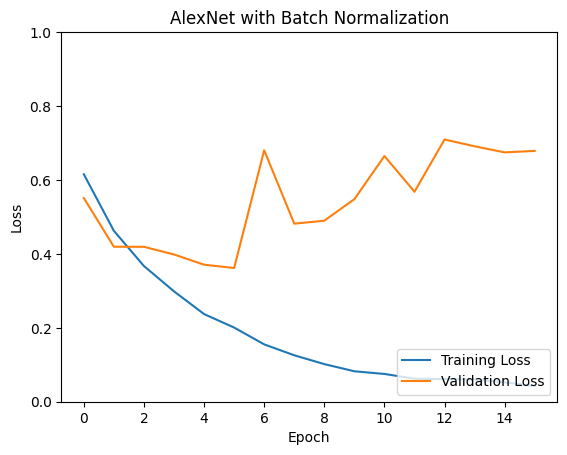

In [ ]:
plt.plot(modified_model_history.history['loss'], label='Training Loss')
plt.plot(modified_model_history.history['val_loss'], label = 'Validation Loss')
plt.title('AlexNet with Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()